
# **QAI Portfolio Optimization PoC**



Attempting to download data via yfinance...


/tmp/ipython-input-1878494448.py:56: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start, end=end, progress=False, threads=False)


Downloaded 677 rows of prices for 25 tickers.

Asset summary:
          Ticker  Annual Return (μ)  Annual Volatility (σ)
 (Close, BMO.TO)           0.193248               0.182118
 (Close, BNS.TO)           0.186822               0.161240
  (Close, CM.TO)           0.319457               0.170783
  (Close, RY.TO)           0.218979               0.151408
  (Close, TD.TO)           0.136296               0.171943
  (High, BMO.TO)           0.190297               0.160610
  (High, BNS.TO)           0.178827               0.142357
   (High, CM.TO)           0.316768               0.158362
   (High, RY.TO)           0.214081               0.132560
   (High, TD.TO)           0.128339               0.154011
   (Low, BMO.TO)           0.199246               0.198101
   (Low, BNS.TO)           0.186703               0.165477
    (Low, CM.TO)           0.323314               0.181128
    (Low, RY.TO)           0.218264               0.142096
    (Low, TD.TO)           0.132475               0.1

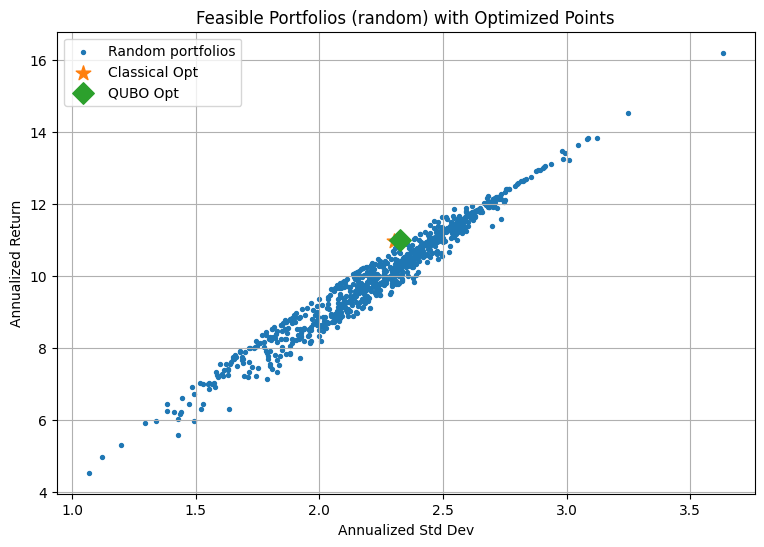


Artifacts saved to /mnt/data/portfolio_poc and zipped at /mnt/data/portfolio_poc.zip
In Colab you can download the zip from the Files panel or use:
from google.colab import files; files.download('/mnt/data/portfolio_poc.zip')  # (uncomment in Colab)

Quick usage notes:
 - To fetch real prices in Colab: !pip install yfinance scipy
 - To run QAOA instead of simulated annealing, replace the solver section with PennyLane or Qiskit implementation.
 - Increase DISCRET_BITS for higher precision (cost: more computation).


/tmp/ipython-input-1878494448.py:286: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "created": datetime.utcnow().isoformat() + "Z",


In [1]:
# QAI Portfolio Optimization PoC (Colab-ready)
# Paste into Google Colab and run.
# Optional installs (uncomment to install in Colab):
# !pip install yfinance scipy stable-baselines3

# --- Imports ---
import os
import json
import math
import random
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Try optional libs
try:
    import yfinance as yf
    YFINANCE_AVAILABLE = True
except Exception:
    YFINANCE_AVAILABLE = False

try:
    from scipy.optimize import minimize
    SCIPY_AVAILABLE = True
except Exception:
    SCIPY_AVAILABLE = False

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# ---------------------
# User-editable parameters
# ---------------------
TICKERS = ["RY.TO", "TD.TO", "BNS.TO", "BMO.TO", "CM.TO"]  # example Canadian bank tickers (adjustable)
START_DATE = "2023-01-01"
END_DATE = datetime.today().strftime("%Y-%m-%d")
RISK_AVERSION = 1.0     # lambda
MAX_WEIGHT = 0.4        # max allocation per asset
MIN_WEIGHT = 0.0
NUM_DAYS = 252          # approx trading days in a year
DISCRET_BITS = 6        # number of bits per asset for QUBO discretization (higher => more precise)
OUTPUT_DIR = "/mnt/data/portfolio_poc"  # Colab-friendly path to save artifacts

# ---------------------
# Data fetch / synthetic fallback
# ---------------------
def fetch_price_data(tickers, start, end):
    if YFINANCE_AVAILABLE:
        try:
            print("Attempting to download data via yfinance...")
            data = yf.download(tickers, start=start, end=end, progress=False, threads=False)
            if data is None or data.empty:
                raise RuntimeError("yfinance returned empty data")
            # Get 'Adj Close'
            if "Adj Close" in data.columns:
                prices = data["Adj Close"].copy()
            else:
                prices = data.copy()
            prices = prices.dropna(how="any")
            print(f"Downloaded {prices.shape[0]} rows of prices for {len(prices.columns)} tickers.")
            return prices
        except Exception as e:
            print("yfinance fetch failed:", e)
    print("Falling back to synthetic data (no internet / yfinance).")
    days = NUM_DAYS
    mu = np.random.uniform(0.05, 0.2, len(tickers)) / NUM_DAYS  # daily mean returns
    sigma = np.random.uniform(0.01, 0.03, len(tickers))  # daily vol
    dates = pd.bdate_range(end=datetime.today(), periods=days)
    prices = pd.DataFrame(index=dates, columns=tickers, dtype=float)
    for i, t in enumerate(tickers):
        r = np.random.normal(loc=mu[i], scale=sigma[i], size=days)
        prices[t] = 100 * np.cumprod(1 + r)  # start at 100
    return prices

prices = fetch_price_data(TICKERS, START_DATE, END_DATE)
returns = prices.pct_change().dropna()
mean_returns = returns.mean() * NUM_DAYS
cov_matrix = returns.cov() * NUM_DAYS

print("\nAsset summary:")
summary_df = pd.DataFrame({
    "Ticker": returns.columns,
    "Annual Return (μ)": mean_returns.values,
    "Annual Volatility (σ)": np.sqrt(np.diag(cov_matrix)),
})
print(summary_df.to_string(index=False))

# ---------------------
# Classical baseline: mean-variance optimization
# ---------------------
n = len(returns.columns)

def classical_markowitz(mu, Sigma, risk_aversion=1.0, bounds=(0,1), max_weight=0.4):
    """
    Solve max w^T mu - risk_aversion * w^T Sigma w
    subject to sum(w)=1 and bounds on w using scipy.optimize (SLSQP) if available.
    """
    if SCIPY_AVAILABLE:
        def objective(w):
            return - (w.dot(mu) - risk_aversion * w.dot(Sigma.dot(w)))
        cons = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0},)
        bnds = tuple((bounds[0], min(bounds[1], max_weight)) for _ in range(len(mu)))
        x0 = np.repeat(1.0 / len(mu), len(mu))
        res = minimize(objective, x0, bounds=bnds, constraints=cons, method='SLSQP',
                       options={'ftol': 1e-9, 'maxiter': 1000})
        if not res.success:
            print("Classical optimizer warning:", res.message)
        w = np.clip(res.x, bounds[0], max_weight)
        if w.sum() == 0:
            w = np.repeat(1.0 / len(mu), len(mu))
        else:
            w = w / np.sum(w)
        return w, res
    else:
        # Simple projected gradient descent fallback
        print("Scipy not available: using projected gradient descent fallback.")
        w = np.repeat(1.0 / n, n)
        lr = 0.01
        for it in range(5000):
            grad = - (mu - 2 * risk_aversion * (Sigma.dot(w)))
            w = w - lr * grad
            w = np.clip(w, bounds[0], max_weight)
            if w.sum() == 0:
                w = np.repeat(1.0 / n, n)
            else:
                w = w / w.sum()
        return w, None

classical_weights, classical_res = classical_markowitz(mean_returns.values, cov_matrix.values,
                                                       risk_aversion=RISK_AVERSION,
                                                       bounds=(MIN_WEIGHT, 1.0),
                                                       max_weight=MAX_WEIGHT)

def portfolio_metrics(w, mu, Sigma):
    exp_return = float(w.dot(mu))
    variance = float(w.dot(Sigma.dot(w)))
    std = math.sqrt(variance)
    sharpe = exp_return / std if std > 0 else float("nan")
    return {"return": exp_return, "variance": variance, "std": std, "sharpe": sharpe}

classical_metrics = portfolio_metrics(classical_weights, mean_returns.values, cov_matrix.values)

print("\nClassical optimized weights:")
for t, wt in zip(returns.columns, classical_weights):
    print(f"{t}: {wt:.4f}")
print("Classical metrics:", classical_metrics)

# ---------------------
# Quantum-inspired QUBO via discretization + Simulated Annealing
# ---------------------
B = DISCRET_BITS
levels = 2 ** B

def decode_bits_to_weights(bit_array):
    # bit_array shape: (n, B)
    weights = []
    for i in range(n):
        bits = bit_array[i]
        value = 0
        for b in range(B):
            value += int(bits[b]) * (2 ** b)
        frac = value / (levels - 1)
        weights.append(frac * MAX_WEIGHT)
    w = np.array(weights, dtype=float)
    if w.sum() > 0:
        w = w / w.sum()
    else:
        w = np.repeat(1.0 / n, n)
    return w

def qubo_energy(bit_array, mu, Sigma, risk_aversion=1.0):
    w = decode_bits_to_weights(bit_array)
    # We minimize negative objective
    val = - (w.dot(mu) - risk_aversion * w.dot(Sigma.dot(w)))
    return val

def simulated_annealing_qubo(mu, Sigma, bits=B, init_temp=1.0, final_temp=1e-3, alpha=0.995, steps_per_temp=200):
    bit_array = np.random.randint(0, 2, size=(n, bits))
    best_bits = bit_array.copy()
    best_energy = qubo_energy(bit_array, mu, Sigma, RISK_AVERSION)
    current_bits = bit_array.copy()
    current_energy = best_energy
    T = init_temp
    iter_count = 0
    while T > final_temp:
        for _ in range(steps_per_temp):
            i = np.random.randint(0, n)
            b = np.random.randint(0, bits)
            new_bits = current_bits.copy()
            new_bits[i, b] = 1 - new_bits[i, b]
            new_energy = qubo_energy(new_bits, mu, Sigma, RISK_AVERSION)
            delta = new_energy - current_energy
            if delta < 0 or np.random.rand() < np.exp(-delta / T):
                current_bits = new_bits
                current_energy = new_energy
                if new_energy < best_energy:
                    best_energy = new_energy
                    best_bits = new_bits.copy()
        T = T * alpha
        iter_count += 1
    return best_bits, best_energy, iter_count

print("\nRunning quantum-inspired simulated annealing (this may take a little while)...")
best_bits, best_energy, sa_iters = simulated_annealing_qubo(mean_returns.values, cov_matrix.values,
                                                            bits=B, init_temp=1.0, final_temp=1e-3,
                                                            alpha=0.995, steps_per_temp=200)
qubo_weights = decode_bits_to_weights(best_bits)
qubo_metrics = portfolio_metrics(qubo_weights, mean_returns.values, cov_matrix.values)

print(f"Simulated annealing finished in {sa_iters} temperature steps.")
print("\nQUBO (quantum-inspired) optimized weights:")
for t, wt in zip(returns.columns, qubo_weights):
    print(f"{t}: {wt:.4f}")
print("QUBO metrics:", qubo_metrics)

# ---------------------
# Comparison and plotting
# ---------------------
comparison = pd.DataFrame({
    "Ticker": list(returns.columns),
    "Classical Weight": classical_weights,
    "QUBO Weight": qubo_weights
})
print("\nWeights comparison:")
print(comparison.to_string(index=False))

metrics_df = pd.DataFrame({
    "Method": ["Classical", "QUBO (SimAnneal)"],
    "Return": [classical_metrics["return"], qubo_metrics["return"]],
    "StdDev": [classical_metrics["std"], qubo_metrics["std"]],
    "Variance": [classical_metrics["variance"], qubo_metrics["variance"]],
    "Sharpe": [classical_metrics["sharpe"], qubo_metrics["sharpe"]],
})
print("\nPortfolio metrics comparison:")
print(metrics_df.to_string(index=False))

def random_portfolios(mu, Sigma, num_portfolios=1000):
    rets = []
    vols = []
    weights_list = []
    for _ in range(num_portfolios):
        w = np.random.rand(n)
        w = np.clip(w, 0, MAX_WEIGHT)
        if w.sum() == 0:
            w = np.repeat(1.0 / n, n)
        else:
            w = w / w.sum()
        m = float(w.dot(mu))
        v = float(w.dot(Sigma.dot(w)))
        rets.append(m)
        vols.append(math.sqrt(v))
        weights_list.append(w)
    return np.array(rets), np.array(vols), np.array(weights_list)

rand_rets, rand_vols, _ = random_portfolios(mean_returns.values, cov_matrix.values, num_portfolios=800)

plt.figure(figsize=(9,6))
plt.scatter(rand_vols, rand_rets, s=8, label="Random portfolios")
plt.scatter(classical_metrics["std"], classical_metrics["return"], s=120, marker='*', label="Classical Opt")
plt.scatter(qubo_metrics["std"], qubo_metrics["return"], s=120, marker='D', label="QUBO Opt")
plt.xlabel("Annualized Std Dev")
plt.ylabel("Annualized Return")
plt.title("Feasible Portfolios (random) with Optimized Points")
plt.legend()
plt.grid(True)
plt.show()

# ---------------------
# Save artifacts
# ---------------------
output_dir = Path(OUTPUT_DIR)
output_dir.mkdir(parents=True, exist_ok=True)

script_path = output_dir / "portfolio_poc.py"
with open(script_path, "w") as f:
    f.write("# portfolio_poc.py - extracted PoC script\n")
    f.write("# Use the interactive Colab cell to run the full PoC\n")

nb_text = {
    "title": "QAI Portfolio Optimization PoC",
    "created": datetime.utcnow().isoformat() + "Z",
    "parameters": {
        "tickers": TICKERS,
        "start": START_DATE,
        "end": END_DATE,
        "discret_bits": DISCRET_BITS
    },
    "instructions": [
        "0. (Optional) pip install yfinance scipy in Colab for real data and better optimizer",
        "1. Run the notebook cell",
        "2. Adjust TICKERS, RISK_AVERSION, MAX_WEIGHT, DISCRET_BITS if required"
    ]
}
with open(output_dir / "poc_info.json", "w") as f:
    json.dump(nb_text, f, indent=2)

# Create zip
import zipfile
zip_path = str(output_dir.parent / "portfolio_poc.zip")
with zipfile.ZipFile(zip_path, "w", compression=zipfile.ZIP_DEFLATED) as zf:
    zf.write(script_path, arcname="portfolio_poc.py")
    zf.write(output_dir / "poc_info.json", arcname="poc_info.json")

print(f"\nArtifacts saved to {output_dir} and zipped at {zip_path}")
print("In Colab you can download the zip from the Files panel or use:")
print(f"from google.colab import files; files.download('{zip_path}')  # (uncomment in Colab)")

# Quick usage notes
print("\nQuick usage notes:")
print(" - To fetch real prices in Colab: !pip install yfinance scipy")
print(" - To run QAOA instead of simulated annealing, replace the solver section with PennyLane or Qiskit implementation.")
print(" - Increase DISCRET_BITS for higher precision (cost: more computation).")
